# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

In [173]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")

In [174]:
penguins_df.shape

(344, 5)

In [175]:
#Check for features distribution
display(penguins_df.head())

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [176]:
# Check for NaN
des = penguins_df.describe()
des.loc['NaN'] = penguins_df.isna().sum()
des.loc['%NaN'] = (penguins_df.isna().mean())*100
des
#Flipper_lenght_mm has outliers

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000
NaN,2.000000,2.000000,2.000000,2.000000
%NaN,0.581395,0.581395,0.581395,0.581395


In [177]:
#Eliminate NaN
penguins_df = penguins_df.dropna()

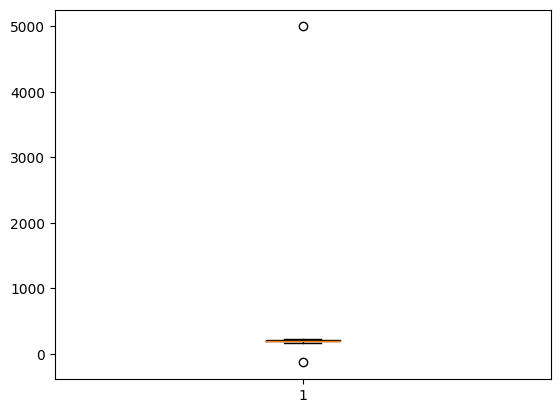

In [178]:
# Check for outliers
plt.boxplot(penguins_df['flipper_length_mm'])
plt.show()

In [179]:
penguins_df[penguins_df['flipper_length_mm']>4000]
penguins_df[penguins_df['flipper_length_mm']<0]
penguins_clean = penguins_df.drop([9,14])

In [180]:
penguins_clean.shape

(333, 5)

In [181]:
#Pre-process

# One-hot econding for categorical feature

dummies = pd.get_dummies(penguins_clean)


#option with label encoder and one hot encoding

#from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#le = LabelEncoder()
#label_encoding = le.fit_transform(penguins_clean2['sex'])

#penguins_clean2['sex_le'] = label_encoding

#onehot_encoder = OneHotEncoder(sparse=False)

#one_hot_encoding = onehot_encoder.fit_transform(label_encoding.reshape(-1,1))

#one_hot_encoding_df = pd.DataFrame(one_hot_encoding, columns=le.classes_, dtype=int)

penguin_encoding = penguins_clean.join(dummies[['sex_FEMALE', 'sex_MALE']]).drop('sex', axis=1)

display(penguin_encoding.head())

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
4,36.7,19.3,193.0,3450.0,1,0
5,39.3,20.6,190.0,3650.0,0,1


In [182]:
# Scaler variables

scaler = StandardScaler()
x= scaler.fit_transform(penguin_encoding)

penguins_preprocessed = pd.DataFrame(data=x, columns=penguin_encoding.columns)
penguins_preprocessed = penguins_preprocessed.dropna()
#print(penguins_preprocessed.isna().sum(), penguins_preprocessed.shape)

In [183]:
# PCA
import numpy as np
pca = PCA()
pca_fit = pca.fit(penguins_preprocessed)
explained_variance = pca_fit.explained_variance_ratio_
threshold = 0.1
n_components = sum(explained_variance > threshold)
print(n_components)
pca_selected = PCA(n_components=n_components)
penguins_pca = pca_selected.fit_transform(penguins_preprocessed)

2


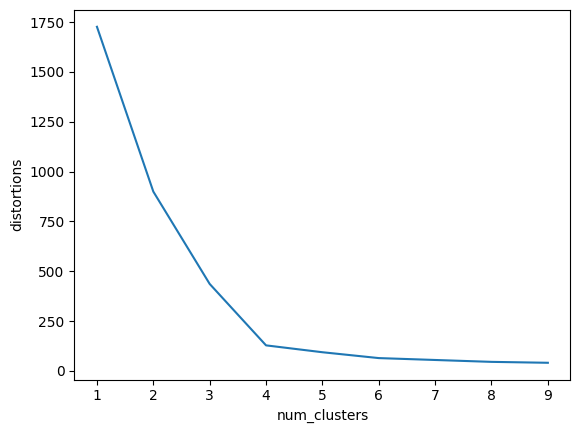

In [184]:
# Elbow methon on KMeans to select n_cluster

from scipy.cluster.vq import kmeans, vq
from numpy import random
import seaborn as sns

#random.seed(42)

distortions = []
num_clusters = range (1,10)

for i in num_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(penguins_pca)
    distortions.append(kmeans.inertia_)
    #cluster_centers, distortion = kmeans(penguins_pca, i)
    #distortions.append(distortion)
    
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions':distortions})

sns.lineplot(x='num_clusters', y='distortions', data=elbow_plot)
plt.xticks(num_clusters)
plt.show()

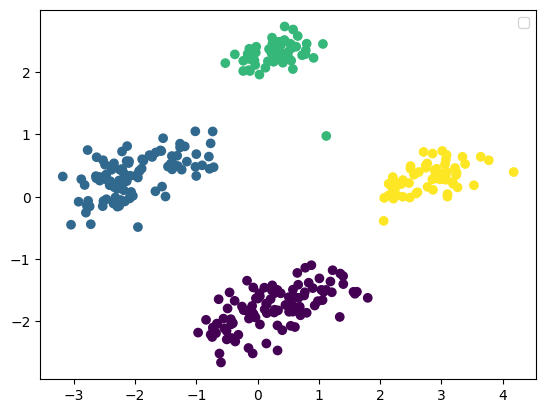

In [185]:
n_clusters=4

kmeans = KMeans(n_clusters, random_state=42)

kmeans.fit(penguins_pca)

#pca2 = PCA(n_components=2)
#x_pca=pca2.fit_transform(penguins_preprocessed)

plt.scatter(penguins_pca[:,0], penguins_pca[:,1], c=kmeans.labels_)
plt.legend()
plt.show()


In [186]:
penguins_clean['label'] = kmeans.labels_
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm','label']
stat_penguins = penguins_clean[numeric_columns].groupby('label').mean()
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm
label,,,
0,43.878302,19.111321,194.764151
1,40.217757,17.611215,189.046729
2,45.545763,14.262712,212.779661
3,49.473770,15.718033,221.540984
